# Rolling Windows Tutorial

This is the beginning of a tutorial for using the version of Rolling Windows developed in April 2024.

In [1]:
# This is only necessary for running the module from a local folder
import sys
sys.path.insert(1, "C:/Users/scott/Documents/apis/lexos-to-clean/working_dev/")

import spacy

## Load a spaCy Document

Before starting with Rolling Windows, we'll load a text and convert it to a spaCy document. Eventually, this should be done with Lexos loader.

In [2]:
model = "en_core_web_sm"
nlp = spacy.load(model)
with open("text_md.txt", "r", encoding="utf-8") as f:
    text = f.read()
doc = nlp(text)

## Import Rolling Windows

Note that the code should eventually just say `import rollingwindows` once the module is integrated into Lexos.

In [3]:
import rollingwindows2 as rollingwindows

## Assign Milestones

Currently, the Lexos API's `milestones` submodule is the one that works. It has been copied into the `rollingwindows2` folder so that it can be importe locally without messing with paths.

In [4]:
from rollingwindows2 import milestones

ms = milestones.Milestones(doc, nlp="en_core_web_sm")
spans = ms.get_matches(patterns=["PARAGRAPH"], mode="string")
ms.set_milestones(spans)
ms.to_list()

[{'text': 'PARAGRAPH',
  'characters': 'PARAGRAPH',
  'start_token': 0,
  'end_token': 1,
  'start_char': 0,
  'end_char': 8},
 {'text': 'PARAGRAPH',
  'characters': 'PARAGRAPH',
  'start_token': 67,
  'end_token': 68,
  'start_char': 331,
  'end_char': 339},
 {'text': 'PARAGRAPH',
  'characters': 'PARAGRAPH',
  'start_token': 125,
  'end_token': 126,
  'start_char': 655,
  'end_char': 663},
 {'text': 'PARAGRAPH',
  'characters': 'PARAGRAPH',
  'start_token': 166,
  'end_token': 167,
  'start_char': 871,
  'end_char': 879},
 {'text': 'PARAGRAPH',
  'characters': 'PARAGRAPH',
  'start_token': 206,
  'end_token': 207,
  'start_char': 1095,
  'end_char': 1103},
 {'text': 'PARAGRAPH',
  'characters': 'PARAGRAPH',
  'start_token': 327,
  'end_token': 328,
  'start_char': 1719,
  'end_char': 1727},
 {'text': 'PARAGRAPH',
  'characters': 'PARAGRAPH',
  'start_token': 441,
  'end_token': 442,
  'start_char': 2293,
  'end_char': 2301},
 {'text': 'PARAGRAPH',
  'characters': 'PARAGRAPH',
  'star

In [5]:
milestone_labels = [
    {x["text"]: (x["start_char"], x["end_char"])}
    for x in ms.to_list()
]
milestone_labels

[{'PARAGRAPH': (0, 8)},
 {'PARAGRAPH': (331, 339)},
 {'PARAGRAPH': (655, 663)},
 {'PARAGRAPH': (871, 879)},
 {'PARAGRAPH': (1095, 1103)},
 {'PARAGRAPH': (1719, 1727)},
 {'PARAGRAPH': (2293, 2301)},
 {'PARAGRAPH': (2783, 2791)},
 {'PARAGRAPH': (3274, 3282)}]

## Create a Rolling Windows Object

A `RollingWindows` object must be initialised with a doc and the name of a model. It can also optionally be initialised with `patterns`, which may be a string, spaCy rule, or a list of either. RollingWindow objects have a metadata attribute, which gives access to information about the object's configuration.

In [6]:
rw = rollingwindows.RollingWindows(doc, model=model, patterns="the")
rw.metadata

{'model': 'en_core_web_sm'}

Overview of `RollingWindows` attributes:

- `doc` (required): The input doc
- `model` (required): The name of the model used to produce the doc
- `patterns` (optional): A string or regex pattern, a spaCy rule matcher rule, or a list of any of these to be searched in windows.
- `metadata`: A dict produced automatically when the object is instantiated. Values are updated when any of the instance's attributes are changed. 

## Filters

Filters are a way to reduce the token count in a doc without losing token attributes. In the example below, we apply the built-in word filter. The other built-in filter remove stop words.

Filters can be used independently, but, when used with Rolling Windows, they are passed to the `RollingWindows.set_windows()` method using the `filter` keyword. There are two ways to use them with Rolling Windows. The first is to import `filters` (as above) and create an instance of the filter class (e.g. `filters.WordFilter`) with the doc in the Rolling Windows object (i.e. `rw.doc`). Individual filters may take additional keywords.

All filters have an `id` attribute, which is a string name for the filter. If the string name is passed to `set_windows()`, the filter will be loaded from the registry with the default configuration.

In [7]:
from rollingwindows2 import filters

# Create a filter by instantiating the class
wordfilter = filters.WordFilter(rw.doc, exclude_digits=True)
wordfilter.id # "word_filter"

# Alternatively, use the filter's id
# wordfilter = "word_filter"

'word_filter'

Overview of `WordFilter` attributes:

- `id`: "word_filter". Produced automatically when the class is instantiated.
- `doc` (required): A spaCy doc. This will normally be the doc used to create a `RollingWindows` instance.
- `spacy_attrs`: A list of spaCy token attributes to preserve in the filtered doc. The default is the complete list of attributes, but custom extensions will need to be added.
- `exclude`: By default, single spaces and line breaks are not treated as words.
- `exclude_digits`: If `True`, digits will not be treated as words.
- `exclude_roman_numerals`: Same as above for Roman numerals, but only works capitalised Roman numerals.
- `exclude_pattern`: Additional patterns to add to the default `exclude` list. For instance, `"a.+"` would cause all tokens beginning with the letter _a_ not to be treated as words. Patterns can be strings, regex patterns, or a list of either.

Overview of `NonStopwordFilter` attributes:

- `id`: "non_stopword_filter". Produced automatically when the class is instantiated.
- `doc` (required): A spaCy doc. This will normally be the doc used to create a `RollingWindows` instance.
- `additional_stopwords` (optional): A list of stop words to add to those labelled as stop words by the model.
- `case_sensitive`: If `False`, `additional_stopwords` will be converted to lower case, and lower-cased tokens matching items in this list will not be treated as words.

## Custom Filters

Filters are implemented with the `Filter` protocol, which allows you to produce custom filter classes. For instance, you could create a class which returned only tokens starting with the letter "a".

```python
class MyCustomFilter(Filter):
	id: str = "my_custom_filter"

	def __init__(self, doc: spacy.tokens.doc.Doc, *, spacy_attrs: List[str] = SPACY_ATTRS):
        self.doc = doc
        self.spacy_attrs = spacy_attrs
			  
	@property
	def filtered_token_ids(self) -> set:
		"""Get a set of token_ids to keep after filtering."""
		return {token.i for token in self.doc if token.text.startswith("a")}

    def apply(self) -> spacy.tokens.doc.Doc:
        """Apply the filter."""
        return filter_doc(self.doc, self.word_ids, self.spacy_attrs)
```

The `Filter` protocol automatically builds the `metadata` dict and requires an `apply()` method. This submits the doc, the list of token ids to keep, and the spacy attributes to keep to the `filter_doc` function (which must be imported from the `filters` module). The `filters` module also contains the default spacy attributes list. In the example above, the filtering logic is simple enough to be performed in the `filtered_token_ids` property. Additional keywords can be added to the `__init__()` method as needed.

## Set the Windows

Setting the windows generates the windows based on the number of units, the type of unit (characters, tokens, lines, sentences), and other settings, depending on the type of unit. All settings are recorded in the `RollingWindows` object's metadata.

`set_windows()` creates an instance of the `Windows` class, which is a generator assigned to the `windows` attribute of the `RollingWindows` object. You can iterate through the windows with `for rw.windows...`. Note that the `Windows` object contains a generator, which is emptied if you iterate over it -- in that case, you will have to run `set_windows()` again.

At present, `set_windows()` has a timer decorator, which will display the time elapsed.

Overview of `RollingWindows.set_windows()` keywords:

- `n` (required): The number of windows to calculate
- `window_units` (required): The type of units to count when sliding windows: "characters", "lines", "sentences", or "tokens".
- `alignment_mode` (optional): Controls how window edges snap to token boundaries. The default is "strict" (no snapping). The "contract" option will include only tokens completely within the window character boundaries (i.e. some windows may be smaller than `n`). The "expand" option will include all tokens partially within the window character boundaries (i.e. some windows may be larger than `n`).
- `filter` (optional): The name of a filter or a filter object to apply to the document before windows are generated.

In [8]:
print("Setting windows...")

# Using the filter above
# rw.set_windows(1000, "characters", filter=wordfilter)

# Without using a filter
rw.set_windows(50, "characters", alignment_mode="expand")

Setting windows...
Elapsed time: 0.0


## Calculate Rolling Averages

Rolling Windows statistics are calculated using calculator classes ("calculators"), of which there is currently one: `Averages`.

The standard procedure is instantiate a calculator object, supplying all keywords necessary for its configuration. (These need to be discussed below.)

The calculator object is then passed to the `RollingWindows.calculate()` method using the `calculator` keyword. Calculators have `id` and `metadata` attributes. The metadata is added to the `RollingWindows.metadata` when `calculate()` is called.

If a string name for a calculator is passed to `calculate()`, the calculator will be loaded from the registry and instantiated with the default configuration. The calculator will look for patterns and windows in the `RollingWindows` object.

The data calculated is stored in a pandas dataframe in `RollingWindows.result`.

At present, `calculate()` has a timer decorator, which will display the time elapsed.

In [9]:
from rollingwindows2 import calculators

averages = calculators.Averages(
    patterns=rw.patterns,
    windows=rw.windows,
    search_method=rw.metadata["search_method"],
    model="en_core_web_sm"
)

print("Calculating averages...")
rw.calculate(calculator=averages)
rw.result.head()


Calculating averages...
Elapsed time: 0.02991795539855957


,the
0,0.02
1,0.02
2,0.02
3,0.02
4,0.02


Overview of `Averages` Attributes:

- `patterns` (required): A pattern or list of patterns to search in windows. If patterns have already been assigned to the `RollingWindows` instance, you can pass `rw.patterns`.
- `windows` (required): A Windows object containing the windows to search. Generally, you will pass `rw.windows`.
- `search_method` (optional): The preliminary search method to use to match patterns. By default, this "count", which uses the  Python List `count()` method. Other possibilities are "regex", which uses Python's `re.findall()`, `spacy_matcher`, which uses spaCy's Matcher class, and "re_finditer", which uses Python's `re.finditer()`. The `Averages` class attempts to assign an appropriate search method for the pattern type, so this attribute generally does not have to be configured.
- `model` (optional): The language model to be used for using spaCy's Matcher class  to identify patterns in tokens and spans. Generally, this would be `rw.model`.
- `alignment_mode` (optional): Whether to snap searches to token boundaries. Values are "strict", "contract", and "expand".
- `doc` (optional): The "re_finditer" method returns character start and end indexes in the window. Access to the doc from which the windows was generated is necessary to map these to the token indexes in order to use `alignment_mode`. 
- `regex` (optional): Whether to use regex for searching.
- `case_sensitive` (optional): Whether to make searches case-sensitive.


## Custom Calculators

Calculators are implemented with the `Calculator` protocol, which allows you to produce custom calculator classes. A skeleton calculator is given below.

```python
class MyCustomCalculator(Calculator):
	id: str = "my_custom_calculator"

	def __init__(self, patterns: Union[list, str], windows: Iterable):
                self.patterns = patterns
                self.windows = windows
                self.data = None
			  
        def run(self) -> spacy.tokens.doc.Doc:
                """Run the calculator."""
                ...

        def to_df(self) -> pd.DataFrame:
                """Convert the data to a pandas DataFrame."""
                ...
```

The `Calculator` protocol automatically builds the `metadata` dict and requires an `run()` method to perform calculations and save the data to the object's `data` attribute. It also requires a `to_df()` method to convert the data to a pandas DataFrame. The data and DataFrame can take any format, but, if it is to be used for one of the Rolling Windows plotters, it must have patterns as column headers and the calculation for each window in rows.

## Plotting the Data

The Rolling Windows module currently has only one plotter: "rw_simple_plotter". If the name of the plotter is passed to the `RollingWindows.plot()` method using the `plotter` keyword, the resulting figure is save as a matplotlib `Figure` to the `RollingWindows.fig` attribute.

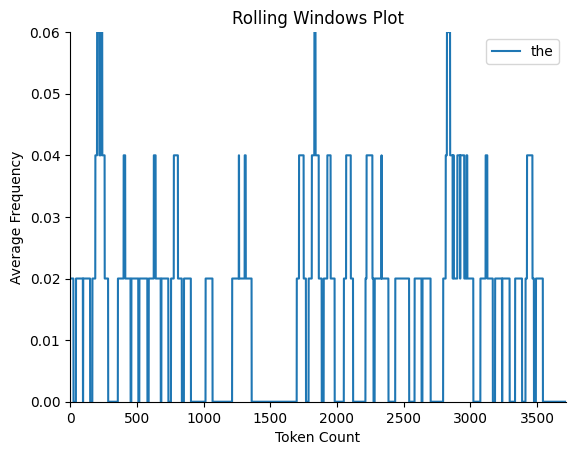

In [10]:
from rollingwindows2 import plotters

rw.plot(plotter="rw_simple_plotter")
rw.fig


## Configuring the Plotter

Using "rw_simple_plotter" calls the `RWSimplePlotter` class with the default configurations. If you want to configure a `RWSimplePlotter` instance, create it with the appropriate keyword, as in the example below. Then pass the class instance to the `RollingWindows.plot()` method as above.

Apart from the `plotter` keyword, `RollingWindows.plot()` has a `show` keyword (a boolean), which, if True, will automatically display the plot, and a `file` keyword, which will automatically save the figure to a file if given a filepath.

In [13]:
plotter = plotters.RWSimplePlotter(
    xlabel="Character Count",
    show_milestones=True,
    show_milestone_labels=True,
    # milestone_labels=milestone_labels,
    # titlepad=64.0
)
rw.plot(plotter=plotter)
rw.fig

TypeError: 'NoneType' object is not iterable

### Overview of RWSimplePlotter Configuration

The `RWSimplePlotter` class has many configuration options, which are described below. Many of them are thin wrappers around matplotlib/pyplot attributes.

- `width`: The figure width in inches.
- `height`: The figure height in inches.
- `figsize`: A tuple containing the figure width and height in inches (overrides the `width` and `height` settings).
- `hide_spines`: A list of ["top", "right", "bottom", "left"] indicating which spines to hide.
- `title`: The title to use for the plot. Default is "Rolling Windows Plot".
- `titlepad`: The padding in points to place between the title and the plot, which may need to be increased if you are showing milestone labels. Default is 6.0 points.
- `title_position`: Show the title on the "bottom" or the "top" of the figure.
- `show_legend`: Whether to show the legend.
- `show_grid`: Whether to show the grid.
- `xlabel`: The text to display along the x axis. Default is "Token Count".
- `ylabel`: The text to display along the y axis. Default is "Average Frequency".
- `show_milestones`: Whether to show the milestone markers.
- `milestone_colors`: The colour or colours to use for milestone markers. See pyplot.vlines().
- `milestone_style`: The style of the milestone markers. See pyplot.vlines().
- `milestone_width`: The width of the milestone markers. See pyplot.vlines().
- `show_milestone_labels`: Whether to show the milestone labels.
- `milestone_labels`: A list of dicts with keys as milestone labels and values as token indexes.
- `milestone_labels_ha`: The horizontal alignment of the milestone labels. See pyplot.annotate().
- `milestone_labels_va`: The vertical alignment of the milestone labels. See pyplot.annotate().
- `milestone_labels_rotation`: The rotation of the milestone labels. See pyplot.annotate().
- `milestone_labels_offset`: A tuple containing the number of pixels along the x and y axes to offset the milestone labels. See pyplot.annotate().
- `milestone_labels_textcoords`: Whether to offset milestone labels by pixels or points. See pyplot.annotate().
- `use_interpolation`: Whether to use interpolation on values.
- `interpolation_num`: Number of values to add between points.
- `interpolation_kind`: Algorithm to use for interpolation.

<span style="color: red;">I need something about milestones, and milestones also need to be tested.</span>

Interpolation uses the `from scipy.interpolate` module to try to smooth out the look of the visualisation by adding points between coordinates in the plot. This can create a more visually-appealing line graph but may also lead cause the graph to be deceptive. It is best to be sure that an interpolated plot clearly indicates the same peaks and valleys found in a plot without interpolation before using the interpolated plot for presentation purposes. 

## Custom Plotters

Plotters are implemented with the `BasePlotter` protocol, which allows you to produce custom plotter classes. A skeleton plotter is given below.

```python
class MyCustomCalculator(BasePlotter):
	id: str = "my_custom_plotter"

	def run(self):
		"""Use a dataframe to plot the rolling means with pyplot."""
		...

	def file(self, path):
		"""Save the plot to a file."""
		...

	def show(self):
		"""Display a plot."""
		...
```

The `BasePlotter` protocol automatically builds the `metadata` dict and requires an `run()` method to generate the plot, a `file()` method to save the plot to a file, and a `show()` method to display the plot.